In [1]:
from pathlib import Path
import sys
import os
import itertools

import matplotlib.pyplot as plt
import numpy as np
import h5py
import torch
import pandas as pd
from scipy.stats import spearmanr

sys.path.append("Dietnet/")
from Dietnet.make_attributions import load_data, load_model
from Dietnet.helpers import dataset_utils as du
from Dietnet.Interpretability import attribution_manager as am
from Dietnet.helpers import mainloop_utils as mlu
from Dietnet.Interpretability import utils

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

In [2]:
#  PyTorch attrs
path = '/home/rochefortc/shared_disk_wd4tb/rochefortc/Dietnetwork/Dietnet2/1000G_EXP/EXP01_2020.07/REPRODUCE_2020.07/REPRODUCE_2020.07_fold0/attrs_avg_true_0.h5'

hf2 = h5py.File(path, 'r')
int_grads_0 = hf2['avg_attr']

path = '/home/rochefortc/shared_disk_wd4tb/rochefortc/Dietnetwork/Dietnet2/1000G_EXP/EXP01_2020.07/REPRODUCE_2020.07/REPRODUCE_2020.07_fold0/attrs_avg_true_2.h5'

hf2 = h5py.File(path, 'r')
int_grads_2 = hf2['avg_attr']

In [3]:
#  theano attr path
which_fold = 0

theano_dir = Path('/home/rochefortc/shared_disk_wd4tb/rochefortc/Dietnetwork/1000G_EXP/EXP02_2_2019.09/final_models/1000_genomes/' +
                  '1000G_2__our_model1.0_lr-3e-05_anneal-0.999_eni-0.02_dni-0.02_accuracy_BN-1_Inpdrp-1.0_EmbNoise-0.0_decmode-regression_hu-100_tenc-100-100_tdec-100-100_hs-100_fold0')
theano_attrs_fname = theano_dir / 'additional_data.npz'

#  Our pipeline using model with Theano weights
theano_attrs_avg_file = theano_dir / 'attrs_theano_avg.h5'

#  this is from Pierre-Lucs implementation
with np.load(theano_attrs_fname, allow_pickle=True, encoding='bytes') as adata:
    avg_int_grads_theano = adata['avg_int_grads']

hf2 = h5py.File(theano_attrs_avg_file, 'r')
#int_grads2 = hf2['int_grad']
avg_int_grads_theano_load_into_pytorch = hf2['avg_attr']

In [4]:
which_fold = 0
seed = 23
train_valid_ratio = 0.75

exp_path = Path('/home/rochefortc/shared_disk_wd4tb/rochefortc/Dietnetwork/Dietnet2/1000G_EXP/EXP01_2020.07')
exp_folder = 'REPRODUCE_2020.07'
full_path = exp_path / exp_folder / '{}_fold{}'.format(exp_folder, which_fold)
#model_path =  full_path / 'model_params.pt'

dataset = 'dataset.npz'
embedding = 'embedding.npz'
folds_indexes = 'folds_indexes.npz'

device = torch.device('cuda:0')

# Load embedding
emb = du.load_embedding(os.path.join(exp_path, embedding), which_fold)
emb = emb.to(device)
emb = emb.float()

# Normalize embedding
emb_norm = (emb ** 2).sum(0) ** 0.5
emb = emb/emb_norm

# Instantiate model
n_feats_emb = emb.size()[1] # input of aux net
n_feats = emb.size()[0] # input of main net


# Hidden layers size
n_hidden_u = 100
n_hidden1_u = 100
n_hidden2_u = 100
# Output layer
n_targets = 26
input_dropout = 0.

#disc_net = load_model(model_path, emb, device, n_feats_emb, n_hidden_u, n_hidden1_u,  n_hidden2_u, n_targets, input_dropout, incl_bias=True)
test_generator, x_test = load_data(exp_path, dataset, folds_indexes, which_fold, seed, train_valid_ratio, device)

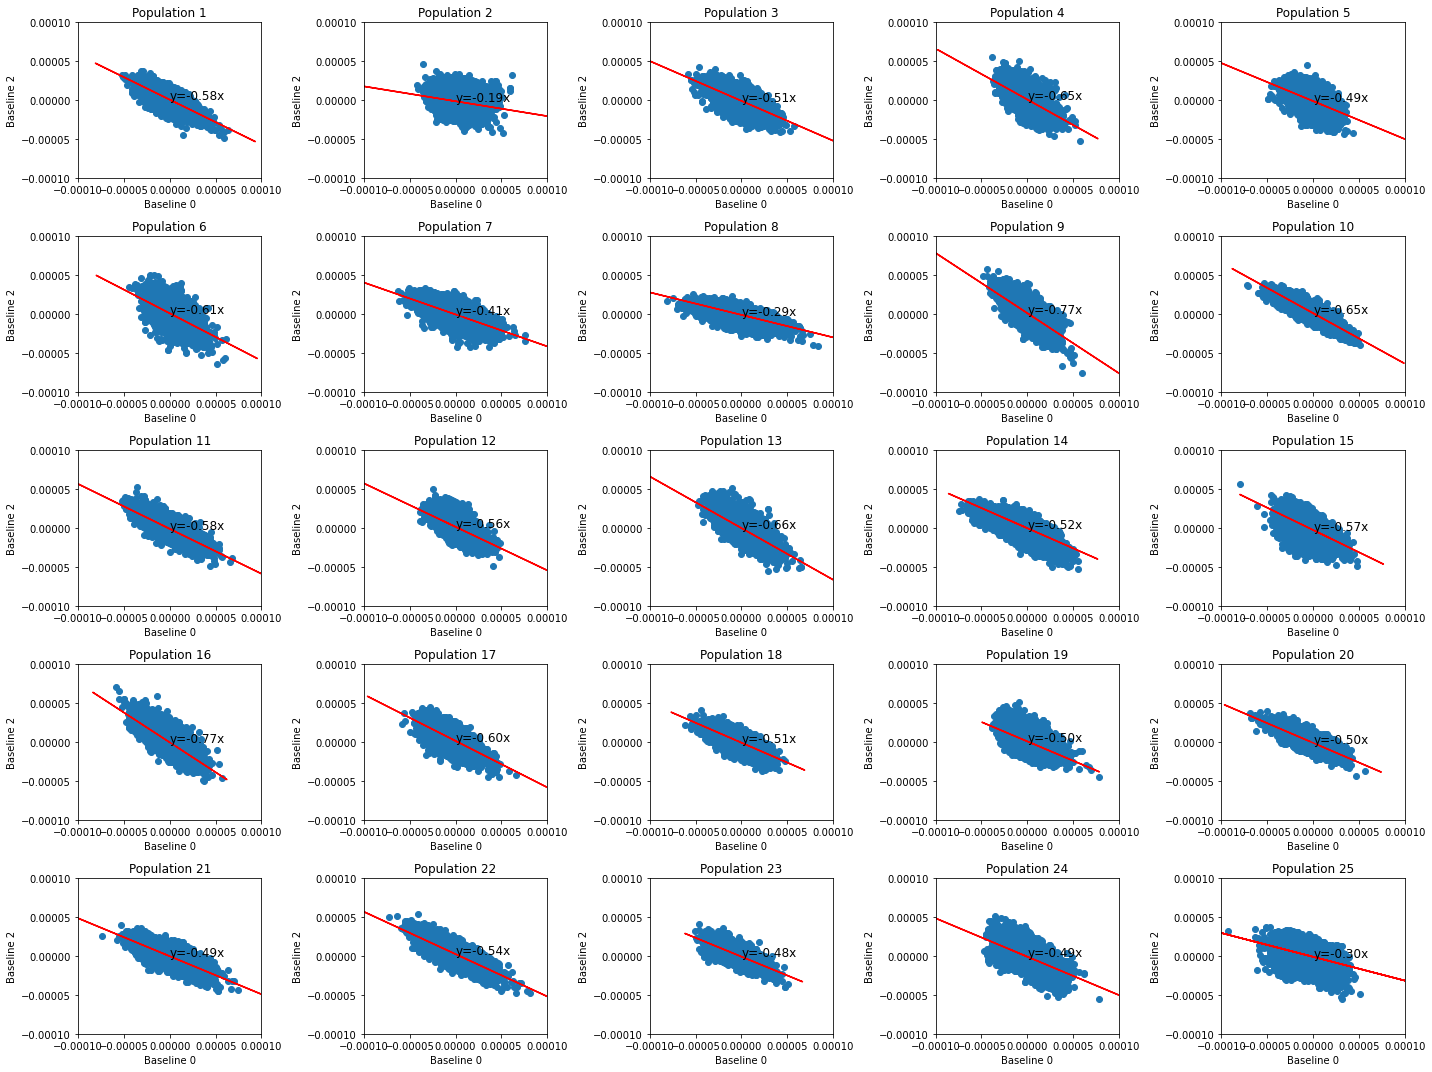

In [5]:
utils.plot_attrs(attr_1=int_grads_0, attr_2=int_grads_2, desc_1='Baseline 0', desc_2='Baseline 2')

##  Histograms

0 nan in 1 but not 2
0 nan in 2 but not 1
0 nan in both 1 and 2


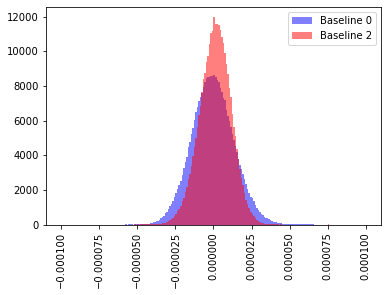

In [6]:
utils.plot_attr_hist(attr_1=int_grads_0, attr_2=int_grads_2, desc_1='Baseline 0', desc_2='Baseline 2', _class=1, variant=1, normalize=False)

##  Visualize Attribution Maps

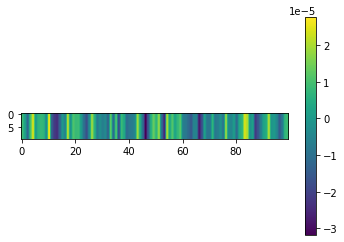

In [8]:
utils.visualize_positions(attr=int_grads_0, start=0, stop=100, variant=1, _class=1)

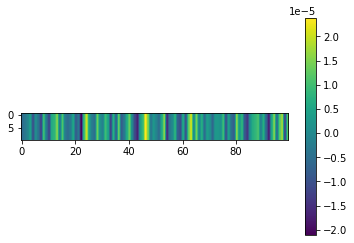

In [9]:
utils.visualize_positions(attr=int_grads_2, start=0, stop=100, variant=1, _class=1)

##  Quantitative Comparison of Maps

In [10]:
#  right now this only does for averages (290k,3,26) !
corrs, pvals = utils.get_corr_each(int_grads_0, int_grads_2, utils.get_spearman_correlation, use_abs=False)
print(corrs)
print(pvals)

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.67162741 -0.75479521 -0.22694239 -0.63715686 -0.58485853 -0.48770364
  -0.54969408 -0.62563402 -0.65400029 -0.70292002 -0.84625777 -0.75197528
  -0.60373877 -0.70303619 -0.74321384 -0.5650798  -0.75271014 -0.68308246
  -0.72806068 -0.52958306 -0.78144864 -0.73901575 -0.76059059 -0.70757612
  -0.59342628 -0.39870447]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1.]
 [0. 0. 0. 

In [12]:
print(corrs[0].mean(), corrs[0].std())
print(corrs[1].mean(), corrs[1].std())
print(corrs[2].mean(), corrs[2].std())

0.0 0.0
-0.6454935492036762 0.13056447791197692
0.0 0.0


##  Single Attribution Comparisons

In [16]:
#  how does variant 1 attributions correlate with attribute 2?

def compute_variant_corr(attr):
    swap_vars = attr[:,:,:]
    swap_vars[:,1,:] = attr[:,2,:]
    swap_vars[:,2,:] = attr[:,0,:]
    swap_vars[:,0,:] = attr[:,1,:]
    corrs, pval = utils.get_corr_each(attr, swap_vars, utils.get_spearman_correlation, use_abs=False)

    print('between 0 and 1: {} +/- {}'.format(corrs[0].mean(), corrs[0].std())) # 0,1
    print('between 1 and 2: {} +/- {}'.format(corrs[1].mean(), corrs[1].std())) # 1,2
    print('between 0 and 2: {} +/- {}'.format(corrs[2].mean(), corrs[2].std())) # 2,0

    return corrs, pval

corrs, pval = compute_variant_corr(int_grads_2)

between 0 and 1: 0.9978528942893019 +/- 0.0007979190136287788
between 1 and 2: 0.0 +/- 0.0
between 0 and 2: 0.0 +/- 0.0


In [18]:
corrs2, pval2 = compute_variant_corr(int_grads_0)

between 0 and 1: 0.0 +/- 0.0
between 1 and 2: 0.9983159054953236 +/- 0.0006738022872257554
between 0 and 2: 0.0 +/- 0.0


In [13]:
#  how does the class attributions correlate, for fixed variant?
# I'll just pick 26 permutations to try out
# (I chose some of these based on which ones the network seems to confuse)
# This is a hack, can be improved as needed

def compute_variant_corr(attr):
    swap_1_2 = attr[:,:,:]
    swap_1_2[:,:,0] = attr[:,:,1] # 0, 25
    swap_1_2[:,:,1] = attr[:,:,4] # 1, 0
    swap_1_2[:,:,2] = attr[:,:,5] # 2, 11
    swap_1_2[:,:,3] = attr[:,:,5] # 3, 16
    swap_1_2[:,:,4] = attr[:,:,10] # 4, 10
    swap_1_2[:,:,5] = attr[:,:,6] # 5, 6
    swap_1_2[:,:,6] = attr[:,:,3] # 6, 3
    swap_1_2[:,:,7] = attr[:,:,5] # 7, 5
    swap_1_2[:,:,8] = attr[:,:,9] # 8, 9
    swap_1_2[:,:,9] = attr[:,:,22] # 9, 22
    swap_1_2[:,:,10] = attr[:,:,5] # 10, 5
    swap_1_2[:,:,11] = attr[:,:,14] # 11,14
    swap_1_2[:,:,12] = attr[:,:,13] # 12, 13
    swap_1_2[:,:,13] = attr[:,:,16] # 13, 16
    swap_1_2[:,:,14] = attr[:,:,23] # 14, 23
    swap_1_2[:,:,15] = attr[:,:,24] # 15, 24
    swap_1_2[:,:,16] = attr[:,:,23] # 16, 23
    swap_1_2[:,:,17] = attr[:,:,22] # 17, 22
    swap_1_2[:,:,18] = attr[:,:,21] # 18, 21
    swap_1_2[:,:,19] = attr[:,:,1] # 19, 1
    swap_1_2[:,:,20] = attr[:,:,2] # 20, 2
    swap_1_2[:,:,21] = attr[:,:,4] # 21, 4
    swap_1_2[:,:,22] = attr[:,:,7] # 22, 7
    swap_1_2[:,:,23] = attr[:,:,8] # 23, 8
    swap_1_2[:,:,24] = attr[:,:,12] # 24, 12
    swap_1_2[:,:,25] = attr[:,:,15] # 25, 15

    return utils.get_corr_each(int_grads_reg, swap_1_2, utils.get_spearman_correlation, use_abs=False)

In [ ]:
#  When compared with a random vector, we see the correlation is small with insignificant p-value
random_vec = np.random.normal(loc=int_grads_reg[:,1,0].mean(), scale=int_grads_reg[:,1,0].std(), size=int_grads_reg.shape)
corrs, pvals = utils.get_corr_each(int_grads_reg, random_vec, utils.get_spearman_correlation, use_abs=False)

In [ ]:
print(corrs)
print(pvals)

In [ ]:
print(corrs[0].mean(), corrs[0].std())
print(corrs[1].mean(), corrs[1].std())
print(corrs[2].mean(), corrs[2].std())

##  Can use MSE as Well

In [ ]:
#  change comparison function
corrs2, pvals2 = utils.get_corr_each(int_grads2, int_grads, utils.get_mse, use_abs=False)
print(corrs2)
print(pvals2)

## "Manhatten" Plots

In [ ]:
#  list of attributions
attrs_to_plot = int_grads[:,1,13]

#r_idx = np.random.choice(range(attrs_to_plot.shape[0]), size=100000)
#attrs_to_plot = np.abs(attrs_to_plot[r_idx])
attrs_to_plot = np.abs(attrs_to_plot)

with np.load(full_path / 'additional_data.npz', allow_pickle=True, encoding='bytes') as adata:
    feature_names = adata['feature_names']
feature_names = feature_names

df = utils.convert_to_df_for_manhatten_plot(attrs_to_plot, feature_names)
utils.make_manhatten_plot(df)

In [ ]:
attrs_to_plot = int_grads[:,1,0]

#r_idx = np.random.choice(range(attrs_to_plot.shape[0]), size=100000)
#attrs_to_plot = np.abs(attrs_to_plot[r_idx])
attrs_to_plot = np.abs(attrs_to_plot)

with np.load(full_path / 'additional_data.npz', allow_pickle=True, encoding='bytes') as adata:
    feature_names = adata['feature_names']
feature_names = feature_names

df = utils.convert_to_df_for_manhatten_plot(attrs_to_plot, feature_names)
utils.make_manhatten_plot(df)

In [ ]:
df.sort_values(by='pvalue', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False)[0:100]